In [26]:

# Question 2: Plan Bid Distributions (2014 vs 2018)
# 1. Loads the ma_data files created (2014 and 2018)
# 2. Reads landscape files for each year
# 3. Reads risk/rebate files for each year
# 4. Merges everything together
# 5. Calculates plan bids
# 6. Creates frequency histograms comparing 2014 vs 2018

In [27]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 140)

BASE = Path("../../..")
INPUT_DIR = BASE / "data" / "input"
OUTPUT_DIR = BASE / "data" / "output"

In [28]:
# Part 1: Read risk/rebate data for 2014 and 2018
def read_risk_rebate_2014() -> pd.DataFrame:
    """
    Read and process 2014 risk/rebate data from Part C and Part D files.
    """
    # Part C file
    partc_path = INPUT_DIR / "risk_rebate_2014" / "2014PartCPlan Level.xlsx"
    
    risk_rebate_a = pd.read_excel(
        partc_path,
        skiprows=3,
        nrows=2824,  # A4:G2828 means rows 4-2828, so 2824 rows
        usecols="A:G",
        names=["contractid", "planid", "contract_name", "plan_type",
               "riskscore_partc", "payment_partc", "rebate_partc"]
    )

# Clean Part C data
    def parse_number(x):
        """Parse numbers like R's parse_number"""
        if pd.isna(x):
            return np.nan
        s = str(x).replace(",", "").replace("$", "")
        try:
            return float(s)
        except:
            return np.nan
    
    risk_rebate_a["riskscore_partc"] = risk_rebate_a["riskscore_partc"].apply(parse_number)
    risk_rebate_a["payment_partc"] = risk_rebate_a["payment_partc"].apply(parse_number)
    risk_rebate_a["rebate_partc"] = risk_rebate_a["rebate_partc"].apply(parse_number)
    risk_rebate_a["planid"] = pd.to_numeric(risk_rebate_a["planid"], errors="coerce")
    risk_rebate_a["year"] = 2014
    
    risk_rebate_a = risk_rebate_a[[
        "contractid", "planid", "contract_name", "plan_type",
        "riskscore_partc", "payment_partc", "rebate_partc", "year"
    ]]
    
    # Part D file
    partd_path = INPUT_DIR / "risk_rebate_2014" / "2014PartDPlans.xlsx"
    
    risk_rebate_b = pd.read_excel(
        partd_path,
        skiprows=3,
        nrows=3898,  # A4:H3902 means 3898 rows
        usecols="A:H",
        names=["contractid", "planid", "contract_name", "plan_type",
               "directsubsidy_partd", "riskscore_partd", "reinsurance_partd",
               "costsharing_partd"]
    )
    
    # Clean Part D data
    risk_rebate_b["directsubsidy_partd"] = risk_rebate_b["directsubsidy_partd"].apply(parse_number)
    risk_rebate_b["reinsurance_partd"] = risk_rebate_b["reinsurance_partd"].apply(parse_number)
    risk_rebate_b["costsharing_partd"] = risk_rebate_b["costsharing_partd"].apply(parse_number)
    risk_rebate_b["riskscore_partd"] = risk_rebate_b["riskscore_partd"].apply(parse_number)
    
    risk_rebate_b["payment_partd"] = (
        risk_rebate_b["directsubsidy_partd"] + 
        risk_rebate_b["reinsurance_partd"] + 
        risk_rebate_b["costsharing_partd"]
    )
    risk_rebate_b["planid"] = pd.to_numeric(risk_rebate_b["planid"], errors="coerce")
    
    risk_rebate_b = risk_rebate_b[[
        "contractid", "planid", "payment_partd",
        "directsubsidy_partd", "reinsurance_partd", "costsharing_partd",
        "riskscore_partd"
    ]]
    
    # Merge Part C and Part D
    final_risk_rebate = risk_rebate_a.merge(
        risk_rebate_b,
        on=["contractid", "planid"],
        how="left"
    )
    
    return final_risk_rebate


def read_risk_rebate_2018() -> pd.DataFrame:
    """
    Read and process 2018 risk/rebate data.
    2018 files have different structure: headers at row 2 (skiprows=2), sheet name is 'result.srx'
    """
    # Part C file
    partc_path = INPUT_DIR / "risk_rebate_2018" / "2018PartCPlanLevel.xlsx"
    
    risk_rebate_a = pd.read_excel(
        partc_path,
        engine="openpyxl",
        sheet_name="result.srx",
        skiprows=2,
        usecols="A:G",
        names=["contractid", "planid", "contract_name", "plan_type",
               "riskscore_partc", "payment_partc", "rebate_partc"]
    )
    
    # Clean Part C data
    def parse_number(x):
        if pd.isna(x):
            return np.nan
        s = str(x).replace(",", "").replace("$", "")
        try:
            return float(s)
        except:
            return np.nan
    
    risk_rebate_a["riskscore_partc"] = risk_rebate_a["riskscore_partc"].apply(parse_number)
    risk_rebate_a["payment_partc"] = risk_rebate_a["payment_partc"].apply(parse_number)
    risk_rebate_a["rebate_partc"] = risk_rebate_a["rebate_partc"].apply(parse_number)
    risk_rebate_a["planid"] = pd.to_numeric(risk_rebate_a["planid"], errors="coerce")
    risk_rebate_a["year"] = 2018
    
    risk_rebate_a = risk_rebate_a[[
        "contractid", "planid", "contract_name", "plan_type",
        "riskscore_partc", "payment_partc", "rebate_partc", "year"
    ]]
    
    # Part D file
    partd_path = INPUT_DIR / "risk_rebate_2018" / "2018PartDPlans.xlsx"
    
    risk_rebate_b = pd.read_excel(
        partd_path,
        engine="openpyxl",
        sheet_name="result.srx",
        skiprows=2,
        usecols="A:H",
        names=["contractid", "planid", "contract_name", "org_type",
               "directsubsidy_partd", "riskscore_partd", "reinsurance_partd",
               "costsharing_partd"]
    )
    
    # Clean Part D data
    risk_rebate_b["directsubsidy_partd"] = risk_rebate_b["directsubsidy_partd"].apply(parse_number)
    risk_rebate_b["reinsurance_partd"] = risk_rebate_b["reinsurance_partd"].apply(parse_number)
    risk_rebate_b["costsharing_partd"] = risk_rebate_b["costsharing_partd"].apply(parse_number)
    risk_rebate_b["riskscore_partd"] = risk_rebate_b["riskscore_partd"].apply(parse_number)
    
    risk_rebate_b["payment_partd"] = (
        risk_rebate_b["directsubsidy_partd"] + 
        risk_rebate_b["reinsurance_partd"] + 
        risk_rebate_b["costsharing_partd"]
    )
    risk_rebate_b["planid"] = pd.to_numeric(risk_rebate_b["planid"], errors="coerce")
    
    risk_rebate_b = risk_rebate_b[[
        "contractid", "planid", "payment_partd",
        "directsubsidy_partd", "reinsurance_partd", "costsharing_partd",
        "riskscore_partd"
    ]]
    
    # Merge Part C and Part D
    final_risk_rebate = risk_rebate_a.merge(
        risk_rebate_b,
        on=["contractid", "planid"],
        how="left"
    )
    
    return final_risk_rebate

In [9]:

# Question 2: Plan Bid Distributions (2014 vs 2018)
# 1. Loads the ma_data files created (2014 and 2018)
# 2. Reads landscape files for each year
# 3. Reads risk/rebate files for each year
# 4. Merges everything together
# 5. Calculates plan bids
# 6. Creates frequency histograms comparing 2014 vs 2018

In [14]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 140)

BASE = Path("../../..")
INPUT_DIR = BASE / "data" / "input"
OUTPUT_DIR = BASE / "data" / "output"

In [24]:
    # Part D file
    partd_path = INPUT_DIR / "risk_rebate_2018" / "2018PartDPlans.xlsx"
    
    risk_rebate_b = pd.read_excel(
        partd_path,
        engine='openpyxl',
        sheet_name='result.srx',
        skiprows=2,
        usecols="A:H",
        names=["contractid", "planid", "contract_name", "org_type",
               "directsubsidy_partd", "riskscore_partd", "reinsurance_partd",
               "costsharing_partd"]
    )

In [30]:
# Part 2: Read landscape data for 2014 and 2018
def _parse_number_like_readr(x) -> float:
    """Parse numbers like R's readr::parse_number"""
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return float("nan")
    s = str(x)
    if s == "":
        return float("nan")
    m = re.search(r"-?\d+(?:\.\d+)?", s.replace(",", ""))
    return float(m.group(0)) if m else float("nan")


def clean_premium_fields(df: pd.DataFrame) -> pd.DataFrame:
    """Clean premium fields by converting dashes to zeros and parsing numbers"""
    for col in ["premium", "partd_deductible"]:
        if col in df.columns:
            df[col] = df[col].astype("string").str.replace("-", "0", regex=False)
            df[col] = df[col].map(_parse_number_like_readr).astype("float64")
    return df


def read_ma_landscape_csv(path: Path) -> pd.DataFrame:
    """Read MA-only landscape file (works for 2014 and 2018)"""
    MA_COLUMNS = [
        "state","county","org_name","plan_name","plan_type","premium","partd_deductible",
        "drug_type","gap_coverage","drug_type_detail","contractid",
        "planid","segmentid","moop","star_rating"
    ]
    
    df = pd.read_csv(
        path,
        skiprows=6,
        header=None,
        names=MA_COLUMNS,
        dtype={"contractid": "string", "planid": "float64"},
        low_memory=False,
        encoding="latin1"
    )
    return clean_premium_fields(df)


def read_mapd_2014_xls(path: Path, sheet: str, nrows: int) -> pd.DataFrame:
    """Read MA-PD 2014 landscape file"""
    MAPD_COLUMNS = [
        "state","county","org_name","plan_name","contractid","planid","segmentid",
        "org_type","plan_type","snp","snp_type","benefit_type","below_benchmark",
        "national_pdp","premium_partc",
        "premium_partd_basic","premium_partd_supp","premium_partd_total",
        "partd_assist_full","partd_assist_75","partd_assist_50","partd_assist_25",
        "partd_deductible","deductible_exclusions","increase_coverage_limit",
        "gap_coverage","gap_coverage_type"
    ]
    
    return pd.read_excel(
        path,
        engine="xlrd",
        sheet_name=sheet,
        skiprows=4,
        nrows=nrows,
        header=None,
        names=MAPD_COLUMNS,
    )


def load_landscape_2014() -> pd.DataFrame:
    """Load and merge 2014 landscape data"""
    landscape_dir = INPUT_DIR / "landscape_2014"
    
    # MA-only data
    ma_path_a = landscape_dir / "2014LandscapeSource file MA_AtoM 05292014.csv"
    ma_data_a = read_ma_landscape_csv(ma_path_a)
    
    ma_path_b = landscape_dir / "2014LandscapeSource file MA_NtoW 05292014.csv"
    ma_data_b = read_ma_landscape_csv(ma_path_b)
    
    ma_data = pd.concat([ma_data_a, ma_data_b], ignore_index=True)
    
    # MA-PD data
    mapd_path = landscape_dir / "2014LandscapeSource file MA 05292014.xls"
    
    mapd_data_a = read_mapd_2014_xls(mapd_path, sheet="MA (States A to M)", nrows=15855)
    mapd_data_b = read_mapd_2014_xls(mapd_path, sheet="MA (states N to W)", nrows=20301)
    
    mapd_data = pd.concat([mapd_data_a, mapd_data_b], ignore_index=True)
    
    # Clean and merge (converted from R mapd.clean.merge function)
    final_landscape = mapd_clean_merge(ma_data, mapd_data, 2014)
    
    return final_landscape


def load_landscape_2018() -> pd.DataFrame:
    """Load and merge 2018 landscape data"""
    landscape_dir = INPUT_DIR / "landscape_2018"
    
    # MA-only data (similar structure to 2014)
    ma_path_a = landscape_dir / "2018LandscapeSource file MA_AtoM 10142017.csv"
    ma_data_a = read_ma_landscape_csv(ma_path_a)  # Same reader works for 2018
    
    ma_path_b = landscape_dir / "2018LandscapeSource file MA_NtoW 10142017.csv"
    ma_data_b = read_ma_landscape_csv(ma_path_b)
    
    ma_data = pd.concat([ma_data_a, ma_data_b], ignore_index=True)
    
    # MA-PD data - the .xls file should contain MA-PD plans
    # Note: 2018 structure might differ from 2014, may need adjustment
    mapd_path = landscape_dir / "2018LandscapeSource file MA 10142017.xls"
    
    # Try reading the Excel file to see its structure
    try:
        # First, check what sheets are available
        xl_file = pd.ExcelFile(mapd_path, engine="xlrd")
        print(f"  2018 Excel sheets: {xl_file.sheet_names}")
        
        # Attempt to read similar to 2014 pattern
        # You may need to adjust sheet names and nrows
        if "MA (States A to M)" in xl_file.sheet_names:
            mapd_data_a = read_mapd_2014_xls(mapd_path, sheet="MA (States A to M)", nrows=15855)
        else:
            # Use first sheet if exact name not found
            mapd_data_a = read_mapd_2014_xls(mapd_path, sheet=xl_file.sheet_names[0], nrows=None)
        
        if "MA (states N to W)" in xl_file.sheet_names:
            mapd_data_b = read_mapd_2014_xls(mapd_path, sheet="MA (states N to W)", nrows=20301)
        else:
            # Use second sheet if exact name not found
            if len(xl_file.sheet_names) > 1:
                mapd_data_b = read_mapd_2014_xls(mapd_path, sheet=xl_file.sheet_names[1], nrows=None)
            else:
                mapd_data_b = pd.DataFrame()
        
        mapd_data = pd.concat([mapd_data_a, mapd_data_b], ignore_index=True)
        
    except Exception as e:
        print(f"  Warning: Could not read 2018 MA-PD file: {e}")
        print(f"  Continuing with MA-only data")
        mapd_data = pd.DataFrame()
    
    # Clean and merge
    if not mapd_data.empty:
        final_landscape = mapd_clean_merge(ma_data, mapd_data, 2018)
    else:
        # If no MA-PD data, just use MA-only
        final_landscape = ma_data.copy()
        final_landscape["year"] = 2018
    
    return final_landscape

In [31]:
# Part 3: Merge function
def mapd_clean_merge(ma_data: pd.DataFrame, mapd_data: pd.DataFrame, year: int) -> pd.DataFrame:
    """
    Clean and merge MA-only and MA-PD landscape data.
    """
    # Tidy MA-only data
    ma_data = ma_data[["contractid", "planid", "state", "county", "premium"]].copy()
    
    # Fill missing premium within groups
    ma_data = ma_data.sort_values(["contractid", "planid", "state", "county"])
    ma_data["premium"] = (
        ma_data.groupby(["contractid", "planid", "state", "county"])["premium"]
        .transform(lambda x: x.ffill().bfill())
    )
    
    # Remove duplicates
    ma_data = ma_data.drop_duplicates(subset=["contractid", "planid", "state", "county"], keep="first")
    
    # Tidy MA-PD data
    mapd_data = mapd_data[[
        "contractid", "planid", "state", "county", "premium_partc",
        "premium_partd_basic", "premium_partd_supp", "premium_partd_total",
        "partd_deductible"
    ]].copy()
    
    mapd_data["planid"] = pd.to_numeric(mapd_data["planid"], errors="coerce")
    
    # Fill missing values within groups
    mapd_data = mapd_data.sort_values(["contractid", "planid", "state", "county"])
    fill_cols = ["premium_partc", "premium_partd_basic", "premium_partd_supp",
                 "premium_partd_total", "partd_deductible"]
    
    for col in fill_cols:
        if col in mapd_data.columns:
            mapd_data[col] = (
                mapd_data.groupby(["contractid", "planid", "state", "county"])[col]
                .transform(lambda x: x.ffill().bfill())
            )
    
    # Remove duplicates
    mapd_data = mapd_data.drop_duplicates(subset=["contractid", "planid", "state", "county"], keep="first")
    
    # Merge
    plan_premiums = ma_data.merge(
        mapd_data,
        on=["contractid", "planid", "state", "county"],
        how="outer"
    )
    
    plan_premiums["year"] = year
    
    return plan_premiums

In [32]:
# Part 4: Calculate plan bids
def calculate_plan_bids(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate plan bids from premium and rebate data.
    Formula from R code:
    - If rebate > 0: bid = payment / riskscore
    - If rebate = 0 and premium > 0: bid = (payment + premium) / riskscore
    """
    df = df.copy()
    
    # Determine basic premium
    df["basic_premium"] = np.where(
        df["rebate_partc"] > 0,
        0,
        np.where(
            ~df["premium"].isna() & df["premium_partc"].isna(),
            df["premium"],
            df["premium_partc"]
        )
    )
    
    # Calculate bid
    df["bid"] = np.where(
        (df["rebate_partc"] == 0) & (df["basic_premium"] > 0),
        (df["payment_partc"] + df["basic_premium"]) / df["riskscore_partc"],
        np.where(
            (df["rebate_partc"] > 0) | (df["basic_premium"] == 0),
            df["payment_partc"] / df["riskscore_partc"],
            np.nan
        )
    )
    
    return df

In [33]:
# Part 5: loading and processing data cumulatively
def process_year_for_bids(year: int, save_enhanced: bool = True) -> pd.DataFrame:
    """
    Process one year: load all data, merge cumulatively, calculate bids.
    Landscape and risk/rebate merge into plan+service area data.
    """
    print(f"\nProcessing {year}...")
    
    # Step 1: Load the MA data we created in Question 1 (plan + service area merged)
    ma_data = pd.read_csv(OUTPUT_DIR / f"ma_data_{year}.csv")
    print(f"  Loaded MA data (plan + service area): {len(ma_data):,} rows")
    
    # Step 2: Load landscape data
    if year == 2014:
        landscape = load_landscape_2014()
    elif year == 2018:
        landscape = load_landscape_2018()
    else:
        raise ValueError(f"Landscape data not available for {year}")
    print(f"  Loaded landscape data: {len(landscape):,} rows")
    
    # Step 3: Load risk/rebate data
    if year == 2014:
        risk_rebate = read_risk_rebate_2014()
    elif year == 2018:
        risk_rebate = read_risk_rebate_2018()
    else:
        raise ValueError(f"Risk/rebate data not available for {year}")
    print(f"  Loaded risk/rebate data: {len(risk_rebate):,} rows")
    
    # Step 4: Merge landscape INTO ma_data
    # Merge on: contractid, planid, state, county
    # Note: ma_data has state_plan and county_plan from the Q1 merge
    merged = ma_data.merge(
        landscape,
        left_on=["contractid", "planid", "state_plan", "county_plan"],
        right_on=["contractid", "planid", "state", "county"],
        how="left",
        suffixes=("", "_landscape")
    )
    print(f"  After landscape merge: {len(merged):,} rows")
    
    # Step 5: Merge risk/rebate INTO the combined dataset
    # Drop duplicate columns that might conflict
    risk_rebate_clean = risk_rebate.drop(columns=["contract_name", "plan_type"], errors="ignore")
    
    merged = merged.merge(
        risk_rebate_clean,
        on=["contractid", "planid"],
        how="left",
        suffixes=("", "_rr")
    )
    print(f"  After risk/rebate merge: {len(merged):,} rows")
    
    # Step 6: Calculate bids
    merged = calculate_plan_bids(merged)
    
    # Step 7: Save enhanced dataset for use in later questions (cumulative data)
    if save_enhanced:
        output_path = OUTPUT_DIR / f"ma_data_enhanced_{year}.csv"
        merged.to_csv(output_path, index=False)
        print(f"  ✓ Saved enhanced data: {output_path}")
        print(f"    This file now has: plan + service area + landscape + risk/rebate + bids")
    
    # Step 8: Filter to valid bids for plotting
    valid_bids = merged[merged["bid"].notna() & (merged["bid"] > 0) & (merged["bid"] < 10000)]
    print(f"  Valid bids for analysis: {len(valid_bids):,} rows")
    
    return valid_bids

In [34]:
# Part 6: Creating the Histograms
def create_bid_histograms():
    """Create frequency histograms comparing 2014 vs 2018 plan bids"""
    
    # Process both years
    data_2014 = process_year_for_bids(2014)
    data_2018 = process_year_for_bids(2018)
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 2014 histogram
    axes[0].hist(data_2014["bid"], bins=50, edgecolor="black", alpha=0.7, color="steelblue")
    axes[0].set_title("Plan Bid Distribution - 2014", fontsize=14, fontweight="bold")
    axes[0].set_xlabel("Plan Bid ($)", fontsize=12)
    axes[0].set_ylabel("Frequency", fontsize=12)
    axes[0].axvline(data_2014["bid"].median(), color="red", linestyle="--", 
                    label=f'Median: ${data_2014["bid"].median():.2f}')
    axes[0].legend()
    axes[0].grid(axis="y", alpha=0.3)
    
    # 2018 histogram
    axes[1].hist(data_2018["bid"], bins=50, edgecolor="black", alpha=0.7, color="darkgreen")
    axes[1].set_title("Plan Bid Distribution - 2018", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Plan Bid ($)", fontsize=12)
    axes[1].set_ylabel("Frequency", fontsize=12)
    axes[1].axvline(data_2018["bid"].median(), color="red", linestyle="--",
                    label=f'Median: ${data_2018["bid"].median():.2f}')
    axes[1].legend()
    axes[1].grid(axis="y", alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "bid_histograms_2014_2018.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("Summary Statistics")
    print("="*60)
    print(f"\n2014 Bids:")
    print(f"  Mean: ${data_2014['bid'].mean():.2f}")
    print(f"  Median: ${data_2014['bid'].median():.2f}")
    print(f"  Std Dev: ${data_2014['bid'].std():.2f}")
    print(f"  Min: ${data_2014['bid'].min():.2f}")
    print(f"  Max: ${data_2014['bid'].max():.2f}")
    
    print(f"\n2018 Bids:")
    print(f"  Mean: ${data_2018['bid'].mean():.2f}")
    print(f"  Median: ${data_2018['bid'].median():.2f}")
    print(f"  Std Dev: ${data_2018['bid'].std():.2f}")
    print(f"  Min: ${data_2018['bid'].min():.2f}")
    print(f"  Max: ${data_2018['bid'].max():.2f}")
    
    print(f"\nChange from 2014 to 2018:")
    print(f"  Mean: ${data_2018['bid'].mean() - data_2014['bid'].mean():.2f}")
    print(f"  Median: ${data_2018['bid'].median() - data_2014['bid'].median():.2f}")


Processing 2014...
  Loaded MA data (plan + service area): 65,095 rows
  Loaded landscape data: 65,569 rows
  Loaded risk/rebate data: 2,824 rows
  After landscape merge: 65,095 rows
  After risk/rebate merge: 65,095 rows


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_8667/3082405953.py:34: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = ma_data.merge(


  ✓ Saved enhanced data: ../../../data/output/ma_data_enhanced_2014.csv
    This file now has: plan + service area + landscape + risk/rebate + bids
  Valid bids for analysis: 51,041 rows

Processing 2018...


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_8667/3082405953.py:10: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  ma_data = pd.read_csv(OUTPUT_DIR / f"ma_data_{year}.csv")


  Loaded MA data (plan + service area): 87,708 rows
  2018 Excel sheets: ['MA (States A to M)', 'Sheet4', 'MA (states N to W)', 'sanctioned', 'Sheet3', 'Sheet2', 'Sheet1']
  Loaded landscape data: 65,901 rows
  Loaded risk/rebate data: 3,129 rows
  After landscape merge: 87,708 rows
  After risk/rebate merge: 87,708 rows


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_8667/3082405953.py:34: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = ma_data.merge(


  ✓ Saved enhanced data: ../../../data/output/ma_data_enhanced_2018.csv
    This file now has: plan + service area + landscape + risk/rebate + bids
  Valid bids for analysis: 76,248 rows


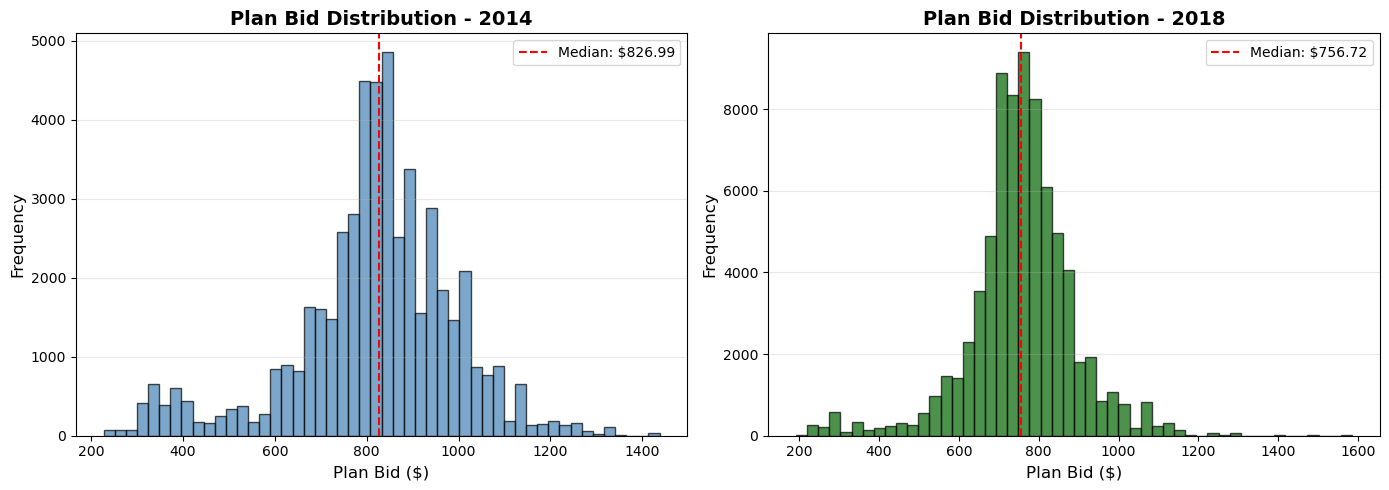


Summary Statistics

2014 Bids:
  Mean: $817.75
  Median: $826.99
  Std Dev: $178.04
  Min: $227.11
  Max: $1437.74

2018 Bids:
  Mean: $755.39
  Median: $756.72
  Std Dev: $134.02
  Min: $191.77
  Max: $1584.73

Change from 2014 to 2018:
  Mean: $-62.35
  Median: $-70.28


In [35]:
if __name__ == "__main__":
    create_bid_histograms()

In [29]:
# Test reading 2018 data
print("Testing read_risk_rebate_2018()...")
data_2018 = read_risk_rebate_2018()
print(f"✓ Successfully loaded 2018 risk/rebate data: {len(data_2018)} rows")
print(f"  Columns: {data_2018.columns.tolist()}")
print(f"  Sample:\n{data_2018.head(2)}")

Testing read_risk_rebate_2018()...
✓ Successfully loaded 2018 risk/rebate data: 3129 rows
  Columns: ['contractid', 'planid', 'contract_name', 'plan_type', 'riskscore_partc', 'payment_partc', 'rebate_partc', 'year', 'payment_partd', 'directsubsidy_partd', 'reinsurance_partd', 'costsharing_partd', 'riskscore_partd']
  Sample:
  contractid  planid  contract_name plan_type  riskscore_partc  payment_partc  \
0      H0028       4  CHA HMO, INC.       HMO             0.98         663.33   
1      H0028       7  CHA HMO, INC.       HMO             1.92         814.22   

   rebate_partc  year  payment_partd  directsubsidy_partd  reinsurance_partd  \
0         65.05  2018          75.79                21.51              29.56   
1         31.04  2018         525.04                42.36             269.44   

   costsharing_partd  riskscore_partd  
0              24.72            0.904  
1             213.24            1.992  
